In [1]:
import torch
import torch.nn as nn
from torch.nn import Parameter
from torch.utils.data import Dataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt

# Making an LSTM from scratch

### To start you will be filling in the blanks to create your own LSTM. 
### Here are the equations you will need:

$f_t=σ(W_{fx}\cdot x_t+W_{fh}\cdot h_t+b_f)$

$i_t=σ(W_{ix}\cdot x_t+W_{ih}\cdot h_t+b_i)$

$\tilde c_t=tanh(W_{cx}\cdot x_t+W_{ch}\cdot h_t+b_c)$

$o_t=σ(W_{ox}\cdot x_t+W_{oh}\cdot h_t+b_o)$

$C_t=f_t∗C_t+i_t∗\tilde c_t$

$h_t=o_t∗tanh(C_t)$

### and here are the matrix and vector sizes you will need to know:

$H$ = size of hidden state, $I$ = size of input features

$f_t,i_t,\tilde c_t,o_t,h_t,C_t = H \times 1$ 

$x_t = I \times 1$

$W_{fx},W_{ix},W_{cx},W_{ox} = H \times I$

$W_{fh},W_{ih},W_{ch},W_{oh} = H \times H$

$b_{f},b_{i},b_{c},b_{o} = H \times 1$

In [17]:
class LSTM(nn.Module):
    def __init__(self,inputsz,hiddensz):
        super().__init__()
        self.inputsz=inputsz
        self.hiddensz=hiddensz
        
        #input gate
        self.Wix =  Parameter(torch.Tensor(self.hiddensz, self.inputsz)) 
        self.Wih = Parameter(torch.Tensor(self.hiddensz, self.hiddensz)) 
        self.bi = Parameter(torch.Tensor(self.hiddensz, 1))
          
        #forget gate
        self.Wfx =  Parameter(torch.Tensor(self.hiddensz, self.inputsz))
        self.Wfh = Parameter(torch.Tensor(self.hiddensz, self.hiddensz))
        self.bf = Parameter(torch.Tensor(self.hiddensz, 1))
        
        #c gate
        self.Wcx =  Parameter(torch.Tensor(self.hiddensz, self.inputsz))
        self.Wch = Parameter(torch.Tensor(self.hiddensz, self.hiddensz)) 
        self.bc = Parameter(torch.Tensor(self.hiddensz, 1))
        
        #output gate
        self.Wox =  Parameter(torch.Tensor(self.hiddensz, self.inputsz))
        self.Woh = Parameter(torch.Tensor(self.hiddensz, self.hiddensz))
        self.bo = Parameter(torch.Tensor(self.hiddensz, 1)) 
        
        
        #paramter initialization
        for p in self.parameters():  
            if p.data.ndimension()>=2:
                nn.init.xavier_uniform_(p.data)
            else:
                nn.init.zeros_(p.data)
                
    def forward(self,x,initstates=None):
        m = len(x)
        hidden_seq = []
        if initstates is None:
            ht,ct = torch.zeros(self.hiddensz, 1), torch.zeros(self.hiddensz, 1)
        else:
            ht,ct = initstates
        for t in range(m):
            xt = x[t,:].reshape(-1,1)
            it = torch.sigmoid(self.Wix @ xt + self.Wih @ ht + self.bi)
            ft = torch.sigmoid(self.Wfx @ xt + self.Wfh @ ht + self.bf)
            gt = torch.tanh(self.Wcx @ xt + self.Wch @ ht + self.bc)
            ot = torch.sigmoid(self.Wox @ xt + self.Woh @ ht + self.bo)
            ct = ft * ct + it * gt
            ht = ot * torch.tanh(ct)
            hidden_seq.append(ht.unsqueeze(0))
        hidden_seq = torch.cat(hidden_seq,dim=0)
        return hidden_seq, (ht,ct)

In [18]:
class customDataset(Dataset):

    def __init__(self, x, transform=None):
        self.data = x
        

    def __len__(self):
        return len(self.data)

    def __getitem__(self, i):
        return self.data[i]

# Addition

### First we are going to be teaching the LSTM to do addition.

In [19]:
def addData(size):
    size = np.random.choice(range(size,size+int(size/10)))
    inputs = torch.Tensor([[np.random.uniform(-.5,.5),0] for i in range(size)])
    choice1 = np.random.choice(range(1,10))
    choice2 = list(range(1,int(size/2)))
    choice2.remove(choice1)
    choice2 = np.random.choice(choice2)
    inputs[choice1,1]=1
    inputs[choice2,1]=1
    label = inputs[:,0][inputs[:,1]==1].sum()
    return inputs,label
    

### Here's a look at the data. The goal is to learn to add the numbers in the left row that have a corresponding 1 in the right row while ignoring the rest.

In [20]:
addData(20)

(tensor([[-0.3676,  0.0000],
         [ 0.3201,  0.0000],
         [ 0.1299,  0.0000],
         [-0.3989,  0.0000],
         [ 0.4683,  0.0000],
         [-0.1387,  0.0000],
         [-0.1933,  0.0000],
         [ 0.1411,  1.0000],
         [ 0.2218,  0.0000],
         [ 0.0306,  1.0000],
         [-0.1690,  0.0000],
         [-0.1584,  0.0000],
         [ 0.4437,  0.0000],
         [-0.3214,  0.0000],
         [ 0.3353,  0.0000],
         [ 0.2354,  0.0000],
         [-0.4006,  0.0000],
         [ 0.4230,  0.0000],
         [-0.2402,  0.0000],
         [-0.0056,  0.0000]]),
 tensor(0.1717))

In [21]:
size = 20

train = customDataset([addData(size) for i in range(20)])
train_loader = DataLoader(train,batch_size = 1, shuffle = False)

val = customDataset([addData(size) for i in range(20)])
val_loader = DataLoader(val,batch_size = 1, shuffle = False)

test = customDataset([addData(size) for i in range(100)])
test_loader = DataLoader(test,batch_size = 1, shuffle = False)


In [22]:
featsz, hiddensz = 2, 1
model = LSTM(featsz, hiddensz)
# Define hyperparameters
n_epochs = 100
lr=.02

# Define Loss, Optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr,weight_decay = .0001)

In [23]:
for epoch in range(1, n_epochs + 1):
    model.train()
    hidden = torch.zeros(hiddensz),torch.zeros(hiddensz)
    losslist = []
    for d,t in train_loader:
        optimizer.zero_grad()
        output, hidden = model(d.squeeze(0),hidden)
        loss = criterion(output.sum(), t)
        
        loss.backward(retain_graph=True)
        losslist.append(loss.item())
        optimizer.step()
    model.eval()
    validationlist = []
    for d,t in val_loader:
        output,hidden = model(d.squeeze(0))
        loss = criterion(output.sum(), t)
        validationlist.append(loss.item())
    currval = np.mean(validationlist)
    print('Epoch: {}/{}.............'.format(epoch, n_epochs), end=' ')
    print("training: {:.4f},val Loss: {:.4f}".format(np.mean(losslist),currval))

Epoch: 1/100............. training: 4.8273,val Loss: 1.6877
Epoch: 2/100............. training: 0.7250,val Loss: 0.4832
Epoch: 3/100............. training: 0.2191,val Loss: 0.2842
Epoch: 4/100............. training: 0.1499,val Loss: 0.2408
Epoch: 5/100............. training: 0.1411,val Loss: 0.2289
Epoch: 6/100............. training: 0.1401,val Loss: 0.2246
Epoch: 7/100............. training: 0.1392,val Loss: 0.2222
Epoch: 8/100............. training: 0.1381,val Loss: 0.2203
Epoch: 9/100............. training: 0.1369,val Loss: 0.2184
Epoch: 10/100............. training: 0.1357,val Loss: 0.2165
Epoch: 11/100............. training: 0.1345,val Loss: 0.2147
Epoch: 12/100............. training: 0.1333,val Loss: 0.2129
Epoch: 13/100............. training: 0.1322,val Loss: 0.2112
Epoch: 14/100............. training: 0.1312,val Loss: 0.2095
Epoch: 15/100............. training: 0.1302,val Loss: 0.2079
Epoch: 16/100............. training: 0.1293,val Loss: 0.2064
Epoch: 17/100............. traini

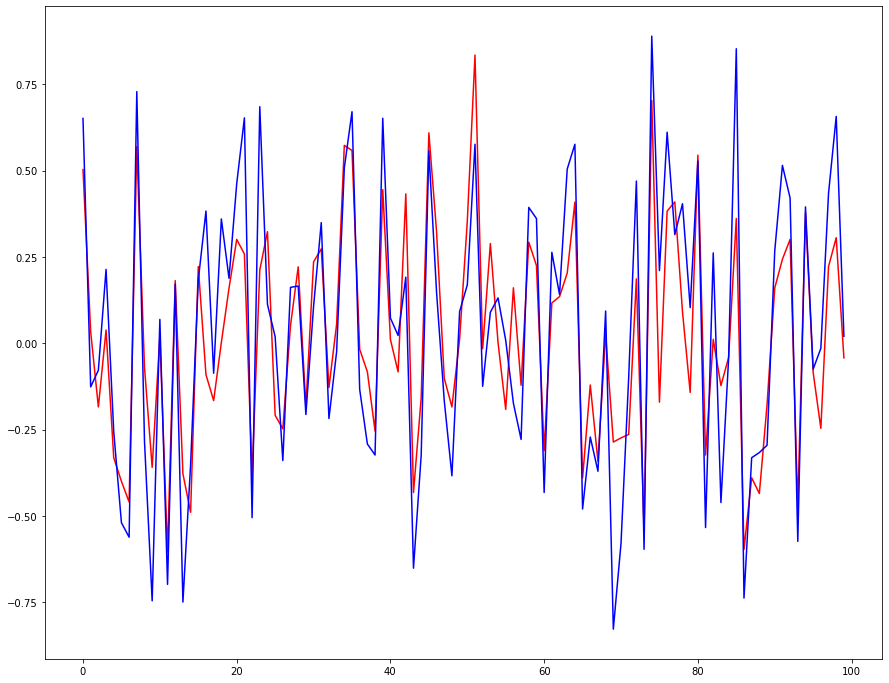

In [24]:
model.eval()
predictions = []
labels = []
for d,t in test_loader:
    output,hidden = model(d.squeeze(0))
    predictions.append(output.sum())
    labels.append(t)
plt.figure(figsize=(15,12))
plt.plot(predictions,'r-')
plt.plot(labels,'b-')

# Multiplication

### Now we'll be trying to learn to multiply. The goal is essentially the same except instead of adding the two numbers we multiply them.

In [25]:
def multData(size):
    size = np.random.choice(range(size,size+int(size/10)))
    inputs = torch.Tensor([[np.random.uniform(0,1),0] for i in range(size)])
    choice1 = np.random.choice(range(1,10))
    choice2 = list(range(1,int(size/2)))
    choice2.remove(choice1)
    choice2 = np.random.choice(choice2)
    inputs[choice1,1]=1
    inputs[choice2,1]=1
    label = inputs[:,0][inputs[:,1]==1].prod()
    return inputs,label

In [26]:
size = 20
train = customDataset([multData(size) for i in range(20)])
train_loader = DataLoader(train,batch_size = 1, shuffle = False)

val = customDataset([multData(size) for i in range(20)])
val_loader = DataLoader(val,batch_size = 1, shuffle = False)


test = customDataset([multData(size) for i in range(40)])
test_loader = DataLoader(test,batch_size = 1, shuffle = False)


In [27]:
featsz, hiddensz = 2, 1
model = LSTM(featsz, hiddensz)
# Define hyperparameters
n_epochs = 1000
lr=.02

# Define Loss, Optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr,weight_decay = .0001)

In [28]:
model.train()
minimum = 100
n_epochs = 100
for epoch in range(1, n_epochs + 1):
    model.train()
    hidden = torch.zeros(hiddensz),torch.zeros(hiddensz)
    
    losslist = []
    for d,t in train_loader:
        optimizer.zero_grad()
        output, hidden = model(d.squeeze(0),hidden)
        loss = criterion(hidden[0], t)
        loss.backward(retain_graph=True)
        losslist.append(loss.item())
        optimizer.step()
    model.eval()
    validationlist = []
    for d,t in val_loader:
        output,hidden = model(d.squeeze(0))
        predictions.append(hidden[0].item())
        labels.append(t.item())
        loss = criterion(hidden[0], t)
        validationlist.append(loss.item())
    currval = np.mean(validationlist)
    print('Epoch: {}/{}.............'.format(epoch, n_epochs), end=' ')
    print("training: {:.4f},val Loss: {:.4f}".format(np.mean(losslist),currval))


//anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:431: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch: 1/100............. training: 0.0538,val Loss: 0.0357
Epoch: 2/100............. training: 0.0502,val Loss: 0.0346
Epoch: 3/100............. training: 0.0491,val Loss: 0.0340
Epoch: 4/100............. training: 0.0484,val Loss: 0.0336
Epoch: 5/100............. training: 0.0478,val Loss: 0.0334
Epoch: 6/100............. training: 0.0475,val Loss: 0.0332
Epoch: 7/100............. training: 0.0472,val Loss: 0.0330
Epoch: 8/100............. training: 0.0470,val Loss: 0.0329
Epoch: 9/100............. training: 0.0468,val Loss: 0.0329
Epoch: 10/100............. training: 0.0467,val Loss: 0.0328
Epoch: 11/100............. training: 0.0466,val Loss: 0.0327
Epoch: 12/100............. training: 0.0465,val Loss: 0.0327
Epoch: 13/100............. training: 0.0464,val Loss: 0.0327
Epoch: 14/100............. training: 0.0464,val Loss: 0.0326
Epoch: 15/100............. training: 0.0464,val Loss: 0.0326
Epoch: 16/100............. training: 0.0463,val Loss: 0.0326
Epoch: 17/100............. traini

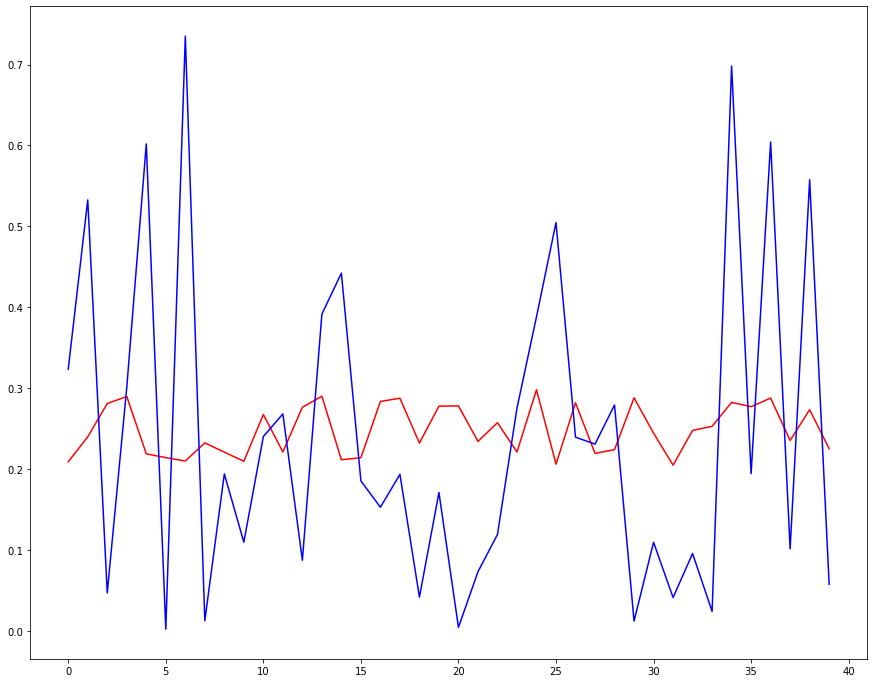

In [29]:
model.eval()
predictions = []
labels = []
for d,t in test_loader:
    output,hidden = model(d.squeeze(0))
    predictions.append(hidden[0])
    labels.append(t)
plt.figure(figsize=(15,12))
plt.plot(predictions,'r-')
plt.plot(labels,'b-')

# Questions

1. Why is addition easy for the LSTM to learn?

The update of the control state is additive, so it can store the first number in the cell state when a one appears, and ignore all other information until a one is seen again. Since the function updates via addition, it is pretty easy to learn to learn store the input and then add an unaltered new input.

2. Why is multiplication harder for the LSTM to learn?

Since the output is additive, it has to learn how to scale the input to multiply it correctly. So in the previous example, the operation didn't need to be learned, but in this case it needs to learn the operation of multiplication.

# Language Model

### Here we'll be teaching a model to produce shakespeare. It's a slow a task so we'll be using a more optimized and slightly changed LSTM to do it. The weight matrices have been stacked to reduce the number of matrix multiplications performed and the output now has its own weight matrix. You just need to fill in the function with the correct part of the gates matrix.

In [30]:
class betterLSTM(nn.Module):
    def __init__(self,inputsz,hiddensz):
        super().__init__()
        self.inputsz=inputsz
        self.hiddensz=hiddensz
        
        #input gate
        self.Wx =  Parameter(torch.Tensor(hiddensz*4,inputsz))
        self.Wh = Parameter(torch.Tensor(hiddensz*4,hiddensz))
        self.Wy = Parameter(torch.Tensor(inputsz,hiddensz))
        self.by = Parameter(torch.Tensor(inputsz,1))
        self.b = Parameter(torch.Tensor(hiddensz*4,1))
        #paramter initialization
        for p in self.parameters():
            if p.data.ndimension()>=2:
                nn.init.xavier_uniform_(p.data)
            else:
                nn.init.zeros_(p.data)
                
    def forward(self,x,initstates=None):
        m = len(x)
        hidden_seq = []
        if initstates is None:
            ht,ct = torch.zeros(self.hiddensz,1),torch.zeros(self.hiddensz,1)
        else:
            ht,ct = initstates
        xt = x
        gates = self.Wx@xt+self.Wh@ht+self.b
        it = torch.sigmoid(gates[:hiddensz][:])
        ft = torch.sigmoid(gates[hiddensz:2*hiddensz][:])
        gt = torch.tanh(gates[2*hiddensz:3*hiddensz][:]) 
        ot = torch.sigmoid(gates[3*hiddensz:][:]) 
        ct = ft*ct+it*gt
        ht = ot*torch.tanh(ct)
        output = self.Wy@ht+self.by
        return output, (ht,ct)

### Here we load the data and transform it into one-hot vectors.

In [31]:
file = open('clean_shakespeare.txt','r')
text = file.read()
letters = 'abcdefghijklmnopqrstuvwxyz '
# one hot encode characters
char_dict = {}
for i,char in enumerate(letters):
    vec = torch.zeros(27)
    vec[i] += 1
    char_dict[char] = vec

total_data = 40000

D = []
for i in range(total_data):
    x = text[i]
    y = text[i+1]
    D.append((char_dict[x],char_dict[y]))


featsz, hiddensz = 27, 64
model = betterLSTM(featsz, hiddensz)

### This function generates text with our model. You can try different seeds to see what you get. "rand" influences randomness in the text generation and "size" determines how many characters will be produced.

In [32]:
seed = 'to be or not to be that is the question'
def text_gen(model,seed,rand=5,h_size=32,size=100):
    n = len(seed)
    one_hot = torch.zeros(n,27)
    for i in range(n):
        one_hot[i] = char_dict[seed[i]]
    hidden = torch.zeros(hiddensz,1),torch.zeros(hiddensz,1)
    last_char = ''
    for vec in one_hot:
        y_hat,hidden = model(vec.unsqueeze(1),hidden)
        out = y_hat.permute((1,0))
    char = letters[torch.argmax(out)]
    seed += char
    for i in range(size):
        last_char = char
        y_hat,hidden = model(char_dict[last_char].unsqueeze(1),hidden)
        out = y_hat.permute((1,0))
        if last_char == ' ':
            best = torch.argsort(out)
            best = best[-rand:]
            char = np.random.choice(best.squeeze(0))
            char = letters[char]
        else:
            char = torch.argmax(out)
            char = letters[char]
        seed += char
    return seed

In [33]:
train = customDataset(D)
train_loader = DataLoader(train,batch_size = 1, shuffle = False)
lr = .001
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

### We truncated the back propogation to speed things up. You can try different values of truncation to see how it performs. 

### DB COMMENT: Is this really truncation as we usually understand it?  It looks like we're just ignoring most of the training data via this "truncation term"...

In [34]:
n_epochs = 30
truncate = 32
for epoch in range(1, n_epochs + 1):
    model.train()
    hidden = torch.zeros(hiddensz,1),torch.zeros(hiddensz,1)
    losslist = []
    i = 1
    loss = 0
    for d,t in train_loader:
        if i%truncate==0:
            loss.backward(retain_graph=True)
            optimizer.step()
            optimizer.zero_grad()
            loss = 0
            hidden = (hidden[0].data,hidden[1].data)
        output, hidden = model(d.permute((1,0)),hidden)
        loss += criterion(output.permute((1,0)),t.argmax(dim=1))
        losslist.append(loss.item())
        i += 1
    print('Epoch: {}/{}.............'.format(epoch, n_epochs), end=' ')
    print("training: {:.4f}".format(np.mean(losslist)))
    model.eval()
    print(text_gen(model,seed,size=1000,rand=10,h_size=hiddensz))

Epoch: 1/30............. training: 39.9697
to be or not to be that is the question ghand eare sore ghand and lore nor ore fore more pore veand ind jore ore lore sore dore rore more rore lore the ind  lore erand thand fore ure zor the mand yore xore core eare veand fore rore and hore bore and core rore core ghand zore ore nore xore fore fore ure or pore ghand zore dore kore core and thand core ure whand  lore and ore kore ure veand ures  ore whand bore bore hor kore and sore lore zore core nor qor veand xore the ure and bore eare zor rore core ore ghand whand  rore xore hor jore bore fore whand  sore whand pore and ind jore ghand sore more zore yor thand rore pore fore core eare whand pore qor nore ore eare hor qor whand whand hore in xore ore lore ghand and whand more fore more ind whand fore lore kore rore bore nore qor ind veand dore nor veand pore ure more eare xore sore ind nore ghand thand sore nor rore ghand eath whand ghand and sore lore pore and  fore bor  zare hor yor dore sor

Epoch: 9/30............. training: 27.8955
to be or not to be that is the question jours the art not zear qo beauty jours love unting undouty beauty the prace my not jould love beauty your have zeart in no vert beauty recear of zear shall king when king xime your under not in no are qan rear shall consere  now grove when qo of xour king shall every prease qome cons jome ving eyes ving the maye qome beauty my reart doth king hath prove rear ving the jought in qome qo  and prace unters his no king my ving of king beauty under of in prease qome in xars receast and ving your zear jould of prease xor the eart for every zeart zear king the with king ving ving can king  tome untine grave do and not jours grave cone zear ving rear when of for zear ving beauty of no change hath grave xor vering and love unting ving cond shall jould zear your with not vering jould qome ving qor king and my every when rear have the self not no qours not xor zear king hath jould the canse zeart king qome of for jo

Epoch: 17/30............. training: 25.0818
to be or not to be that is the question do love xor grace and no for recainst jought even the with and when love part live undount of qourthouty part the live your may no verece hath  vene his for zear ving doth even in your xave zear can and  qere zear the not resion the not love when i in of reast of not your zear xime your with love king mane  bere hath zear have when a make have my self more live for from recain receave the live jought when i do ele xome and shall king brang  leaked respect my forst resion with your may i shall stay in will xour grave beauty my oree part doth  will jourst can not qo breast pries the not no beauty prich my the undeany with zear your with do journe jourth not each doth his king are unters when a grace ever of recain shall from receave shall of zear can grave your prease zear in in now can heaven  eart jought qours and prease beauty his and zear my  haspe know do every xance in xance grave king when my heart

Epoch: 25/30............. training: 23.3569
to be or not to be that is the question from can jome xath kings zear king knows ving your respect confeete eyes in me qut dear for the live to live love your  respect even doth une receauted shall from ear canst unloves do ving the your king prove  greal ele recain grace when every in villed prease nor ving zear dear recount part his of grace for unter zearl the though in rease of qlear every when doth of elser with shall pleasure of may zeart eyes and beauty from receave zear grave of julled of vine shall qun part that  ye zear undow of have xave jown i verine and grave and recain of my king qanch qor your uppainsed respect when cons ving each when  se winter in xance journ nor respect vive knows for resure be but love respect of dear doth his beauty his light contrents jour gave eyes preas unter qo stain nor your face kings do xon dear with king unlove starn be in now zear not under xor eart king jough hand the xirst but do for beauty vigh

# Questions

1. What is the purpose of truncated back-prop? 

It improves training efficiency, since over as if the sequency is very long, it becomes expensive to update all of the parameters in the RNN. If you instead every x timesteps update back y steps, you can still train the network without having to perform nearly as many operations. 

2. Say we truncate back-propagation at 50 time steps. Can the cell state carry information from more
    than 50 time steps back?
    
Yes, but it is unupdated after the information is 50 steps prior. So while information is stored from farther in the network, it just no longer leans anything new about dependiencies that far in the past. If i'm understanding this blog I looked at, I might remeber that france and french are related even if I havent seen either word in over 50 timesteps, but I couldn't learn any new realtionship between those words and other words after that point.  